In [1]:
# Load base packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

# load stats tools
from scipy import stats

# load dataset tools
import datasets

# preprocessing tools
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# load models
from sklearn.linear_model import LogisticRegression
import torch
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from transformers import EvalPrediction

# load eval tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

# Load Data

In [2]:
anno_df = pd.read_csv("data/AnnotatedData/AnnotatedDUGData.tsv", sep="\t")
load_shape = anno_df.shape

# Prepare data

In [3]:
# we will drop the columns which we are not interested in
anno_df = anno_df[
    [
        "Drug number",
        "Line number",
        "Advice Text",
        "AdviceTag1",
        "AdviceTag2",
        "AdviceTag3",
        "AdviceTag4",
    ]
]

## Extract label_ids

In [4]:
labels = (
    anno_df[["AdviceTag1", "AdviceTag2", "AdviceTag3", "AdviceTag4"]]
    .fillna("")
    .astype(str)
)

label_ids = list(set(labels.values.flatten()))

# remove the empty string
label_ids.remove("")


n_label_ids = len(label_ids)
n_label_ids

8

## Encode advice labels

In [5]:
# Create new columns for each unique tag and initialize them with 0
for lab in label_ids:
    anno_df[lab] = 0

# Update the values to 1 where the tag is present
for lab in label_ids:
    mask = labels.apply(lambda row: lab in row.values, axis=1)
    anno_df.loc[mask, lab] = 1

# Drop the original AdviceTag columns
anno_df.drop(
    columns=["AdviceTag1", "AdviceTag2", "AdviceTag3", "AdviceTag4"],
    inplace=True,
)

# Save the transformed data to a new file
anno_df.head()

,Drug number,Line number,Advice Text,Activity or lifestyle related,Drug administration related,Disease or symptom related,Exercise related,Temporal,Other drugs related,Pregnancy related,Food or beverage related
0,0,34,To reduce the risk of dizziness and lightheade...,1,0,0,0,0,0,0,0
1,0,38,This medication may rarely make your blood sug...,0,0,1,0,0,0,0,0
2,0,43,This medication may rarely cause a condition k...,0,0,1,0,0,0,0,0
3,0,64,This drug may make you dizzy or drowsy or caus...,1,0,1,0,0,0,0,0
4,0,66,Avoid alcoholic beverages.,0,0,0,0,0,0,0,1


### Ensure the encoding was correct

In [6]:
assert anno_df.shape[0] == load_shape[0], "Mismatch in number of rows"

# Baseline Predictions


Two baselines will be tested with for the multilabel classification task.

The  baseline will be a random baseline, where the labels are randomly assigned to the advice text.

The baseline will be evaluated using the F1 score, Precision, and Recall.

In [7]:
def rand_baseline_pred(dataset, n_labels=8):
    """
    Randomly predicts a label for each example in the dataset.

    Args:
        dataset (datasets.Dataset): The dataset to predict labels for.

    Returns:
        np.ndarray: The predicted labels.
    """

    return np.random.randint(0, 2, size=(len(dataset), n_labels))

## Load data into dataset

In [8]:
multi_label = datasets.Dataset.from_pandas(anno_df)

## Evaluate the baseline

### Identify ground truth labels

In [9]:
ground_truth = anno_df[label_ids].values

In [10]:
assert ground_truth.shape[0] == load_shape[0], "Mismatch in number of rows"
assert ground_truth.shape[1] == n_label_ids, "Mismatch in number of columns"

### Make predictions and evaluate

#### Random Baseline

In [11]:
# make predictions
rand_preds = rand_baseline_pred(multi_label)
# print(rand_preds.shape)
precision, recall, f1, _ = precision_recall_fscore_support(
    ground_truth, rand_preds, average="micro"
)
print(f"Random Precision: {precision}, Recall: {recall}, F1: {f1}")

Random Precision: 0.210604929051531, Recall: 0.5251396648044693, F1: 0.30063965884861404


In [ ]:
model_results = []

In [ ]:
# save baseline
model_results.append(
    {
        "model": "Random Baseline",
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
)

# Train, Test Split

In [12]:
anno_df.columns

Index(['Drug number', 'Line number', 'Advice Text',
       'Activity or lifestyle related', 'Drug administration related',
       'Disease or symptom related', 'Exercise related', 'Temporal',
       'Other drugs related', 'Pregnancy related', 'Food or beverage related'],
      dtype='object')

In [13]:
# Drop the unneeded columns
anno_df.drop(["Drug number", "Line number"], axis=1, inplace=True)

# Create train test split
train, test = train_test_split(anno_df, test_size=0.2, random_state=42)

# Binary Relevance

For binary relevance we will encode the text using a TF-IDF vectorizer and then train a logistic regression model for each label.

In [14]:
# look at our data
train.head()

,Advice Text,Activity or lifestyle related,Drug administration related,Disease or symptom related,Exercise related,Temporal,Other drugs related,Pregnancy related,Food or beverage related
78,Some products that may interact with this drug...,0,0,0,0,0,1,0,0
29,"Beta-blocker medications (such as metoprolol, ...",0,0,1,0,0,1,0,0
280,Wash your hands after applying the patch.,1,1,0,0,0,0,0,0
507,Lithium passes into breast milk and may have u...,0,0,0,0,0,0,1,0
652,Limit alcoholic beverages.,0,0,0,0,0,0,0,1


## Data encoding with TF-IDF

In [15]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the train data
X_train = vectorizer.fit_transform(train["Advice Text"])

# Transform the test data
X_test = vectorizer.transform(test["Advice Text"])

label_ids = train.columns[1:]
label_ids

Index(['Activity or lifestyle related', 'Drug administration related',
       'Disease or symptom related', 'Exercise related', 'Temporal',
       'Other drugs related', 'Pregnancy related', 'Food or beverage related'],
      dtype='object')

### Training

In [16]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Initialize the model


lr = LogisticRegression(max_iter=1000)
svc = LinearSVC(max_iter=1000)
kn = KNeighborsClassifier(n_neighbors=3)

models = [
    ("Logistic Regression", lr),
    ("Linear SVC", svc),
    ("K-Nearest Neighbors", kn),
]

In [18]:
for model_name, model in models:
    results = pd.DataFrame()

    for label in label_ids:

        print(f"Training model for {model_name}: {label}")

        y_train = train[label]

        y_test = test[label]


        # Train the model


        model.fit(X_train, y_train)


        # Predict the test data


        preds = model.predict(X_test)


        results[label] = preds


    # Evaluate the model

    precision, recall, f1, _ = precision_recall_fscore_support(
        test[label_ids], results, average="micro"
    )


    print(f"\nPrecision: {precision}, Recall: {recall}, F1: {f1}")

    model_results.append(
        {
            "model": f"Binary Relevance - {model_name}",
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }
    )

Training model for Logistic Regression: Activity or lifestyle related
Training model for Logistic Regression: Drug administration related
Training model for Logistic Regression: Disease or symptom related
Training model for Logistic Regression: Exercise related
Training model for Logistic Regression: Temporal
Training model for Logistic Regression: Other drugs related
Training model for Logistic Regression: Pregnancy related
Training model for Logistic Regression: Food or beverage related

Precision: 0.8918918918918919, Recall: 0.6346153846153846, F1: 0.7415730337078652
Training model for Linear SVC: Activity or lifestyle related
Training model for Linear SVC: Drug administration related
Training model for Linear SVC: Disease or symptom related
Training model for Linear SVC: Exercise related
Training model for Linear SVC: Temporal
Training model for Linear SVC: Other drugs related
Training model for Linear SVC: Pregnancy related
Training model for Linear SVC: Food or beverage related



c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dua

Training model for K-Nearest Neighbors: Drug administration related
Training model for K-Nearest Neighbors: Disease or symptom related
Training model for K-Nearest Neighbors: Exercise related
Training model for K-Nearest Neighbors: Temporal
Training model for K-Nearest Neighbors: Other drugs related
Training model for K-Nearest Neighbors: Pregnancy related
Training model for K-Nearest Neighbors: Food or beverage related

Precision: 0.8263665594855305, Recall: 0.8237179487179487, F1: 0.8250401284109149


In [19]:
model_results

[{'model': 'Binary Relevance - Logistic Regression',
  'precision': 0.8918918918918919,
  'recall': 0.6346153846153846,
  'f1': 0.7415730337078652},
 {'model': 'Binary Relevance - Linear SVC',
  'precision': 0.8862068965517241,
  'recall': 0.8237179487179487,
  'f1': 0.8538205980066444},
 {'model': 'Binary Relevance - K-Nearest Neighbors',
  'precision': 0.8263665594855305,
  'recall': 0.8237179487179487,
  'f1': 0.8250401284109149}]

# Transformer Based Model

In [20]:
train, val = train_test_split(train, test_size=0.3, random_state=42)

In [21]:
model_id = "roberta-base"

## Define functions


In [22]:
# metrics function
def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids

    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    preds = (probs > 0.5).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="micro"
    )

    return {"precision": precision, "recall": recall, "f1": f1}

### Load data into dataset

In [23]:
# Load into datasets
train_dataset = datasets.Dataset.from_pandas(train, preserve_index=False)
val_dataset = datasets.Dataset.from_pandas(val, preserve_index=False)
test_dataset = datasets.Dataset.from_pandas(test, preserve_index=False)

In [24]:
# rename Advice Text to text
train_dataset = train_dataset.rename_column("Advice Text", "text")
val_dataset = val_dataset.rename_column("Advice Text", "text")
test_dataset = test_dataset.rename_column("Advice Text", "text")

### Tokenize and split text

In [25]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_id)

In [26]:
def preprocess_text(batch, tokenizer=tokenizer):

    text = batch["text"]
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )

    labels = list(batch.keys())[1:]

    label_array = np.zeros((len(text), len(labels)))

    for i, label in enumerate(labels):
        label_array[:, i] = batch[label]

    inputs["labels"] = label_array

    return inputs

In [27]:
train_encodings = train_dataset.map(preprocess_text, batched=True)
eval_encodings = val_dataset.map(preprocess_text, batched=True)
test_encodings = test_dataset.map(preprocess_text, batched=True)

Map:   0%|          | 0/562 [00:00<?, ? examples/s]

Map:   0%|          | 0/242 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

In [28]:
# format datasets
train_encodings.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)
eval_encodings.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)
test_encodings.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)

#### Label Information

In [29]:
class_names = anno_df.columns[1:].tolist()
n_labels = len(class_names)

id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in enumerate(class_names)}

### Train

In [30]:
training_args = TrainingArguments(
    output_dir=f"./models/advice_labeling/{model_id}",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="steps",
    eval_steps=25,
    logging_dir=f"./logs",
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    save_strategy="steps",
    save_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    report_to="wandb",
)

In [31]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=n_labels, id2label=id2label, label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_encodings,
    eval_dataset=eval_encodings,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [33]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mattcalc. Use `wandb login --relogin` to force relogin


  0%|          | 0/213 [00:00<?, ?it/s]

{'loss': 0.6814, 'grad_norm': 1.322300910949707, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.14}
{'loss': 0.6774, 'grad_norm': 0.8211584687232971, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.28}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.669487714767456, 'eval_precision': 0.19008264462809918, 'eval_recall': 0.18253968253968253, 'eval_f1': 0.18623481781376516, 'eval_runtime': 6.3708, 'eval_samples_per_second': 37.986, 'eval_steps_per_second': 4.866, 'epoch': 0.35}
{'loss': 0.6701, 'grad_norm': 1.1724096536636353, 'learning_rate': 3e-06, 'epoch': 0.42}
{'loss': 0.6597, 'grad_norm': 1.0626227855682373, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.56}
{'loss': 0.6429, 'grad_norm': 1.0735887289047241, 'learning_rate': 5e-06, 'epoch': 0.7}


  0%|          | 0/31 [00:00<?, ?it/s]

c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.6278445720672607, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 11.6574, 'eval_samples_per_second': 20.759, 'eval_steps_per_second': 2.659, 'epoch': 0.7}
{'loss': 0.6042, 'grad_norm': 1.848575234413147, 'learning_rate': 6e-06, 'epoch': 0.85}
{'loss': 0.546, 'grad_norm': 1.4806188344955444, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.99}


  0%|          | 0/31 [00:00<?, ?it/s]

c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.47369861602783203, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 6.888, 'eval_samples_per_second': 35.134, 'eval_steps_per_second': 4.501, 'epoch': 1.06}
{'loss': 0.5076, 'grad_norm': 1.4569116830825806, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.13}
{'loss': 0.4628, 'grad_norm': 1.4756183624267578, 'learning_rate': 9e-06, 'epoch': 1.27}
{'loss': 0.4203, 'grad_norm': 1.452128529548645, 'learning_rate': 1e-05, 'epoch': 1.41}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.37027978897094727, 'eval_precision': 0.9714285714285714, 'eval_recall': 0.35978835978835977, 'eval_f1': 0.5250965250965252, 'eval_runtime': 6.5149, 'eval_samples_per_second': 37.146, 'eval_steps_per_second': 4.758, 'epoch': 1.41}
{'loss': 0.3958, 'grad_norm': 1.5167044401168823, 'learning_rate': 1.1000000000000001e-05, 'epoch': 1.55}
{'loss': 0.3428, 'grad_norm': 1.6159050464630127, 'learning_rate': 1.2e-05, 'epoch': 1.69}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.29794520139694214, 'eval_precision': 0.8790035587188612, 'eval_recall': 0.6534391534391535, 'eval_f1': 0.7496206373292867, 'eval_runtime': 6.7315, 'eval_samples_per_second': 35.95, 'eval_steps_per_second': 4.605, 'epoch': 1.76}
{'loss': 0.3375, 'grad_norm': 1.6502982378005981, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.83}
{'loss': 0.3268, 'grad_norm': 2.5229647159576416, 'learning_rate': 1.4000000000000001e-05, 'epoch': 1.97}
{'loss': 0.2836, 'grad_norm': 1.5716149806976318, 'learning_rate': 1.5e-05, 'epoch': 2.11}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.2639041841030121, 'eval_precision': 0.9026845637583892, 'eval_recall': 0.7116402116402116, 'eval_f1': 0.7958579881656804, 'eval_runtime': 6.5685, 'eval_samples_per_second': 36.842, 'eval_steps_per_second': 4.719, 'epoch': 2.11}
{'loss': 0.2581, 'grad_norm': 1.487571358680725, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.25}
{'loss': 0.2441, 'grad_norm': 1.6025632619857788, 'learning_rate': 1.7000000000000003e-05, 'epoch': 2.39}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.21694350242614746, 'eval_precision': 0.9228295819935691, 'eval_recall': 0.7592592592592593, 'eval_f1': 0.8330914368650216, 'eval_runtime': 6.4196, 'eval_samples_per_second': 37.697, 'eval_steps_per_second': 4.829, 'epoch': 2.46}
{'loss': 0.241, 'grad_norm': 2.373704671859741, 'learning_rate': 1.8e-05, 'epoch': 2.54}
{'loss': 0.2207, 'grad_norm': 2.2314229011535645, 'learning_rate': 1.9e-05, 'epoch': 2.68}
{'loss': 0.2105, 'grad_norm': 1.1340749263763428, 'learning_rate': 2e-05, 'epoch': 2.82}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.1949329525232315, 'eval_precision': 0.9136904761904762, 'eval_recall': 0.8121693121693122, 'eval_f1': 0.8599439775910365, 'eval_runtime': 6.3641, 'eval_samples_per_second': 38.026, 'eval_steps_per_second': 4.871, 'epoch': 2.82}
{'loss': 0.2132, 'grad_norm': 0.9933678507804871, 'learning_rate': 2.1e-05, 'epoch': 2.96}
{'train_runtime': 283.3404, 'train_samples_per_second': 5.95, 'train_steps_per_second': 0.752, 'train_loss': 0.4229025513353482, 'epoch': 3.0}


TrainOutput(global_step=213, training_loss=0.4229025513353482, metrics={'train_runtime': 283.3404, 'train_samples_per_second': 5.95, 'train_steps_per_second': 0.752, 'train_loss': 0.4229025513353482, 'epoch': 3.0})

In [34]:
trainer.evaluate()

  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.1949329525232315,
 'eval_precision': 0.9136904761904762,
 'eval_recall': 0.8121693121693122,
 'eval_f1': 0.8599439775910365,
 'eval_runtime': 16.5094,
 'eval_samples_per_second': 14.658,
 'eval_steps_per_second': 1.878,
 'epoch': 3.0}

In [35]:
# evaluate on test set
test_results = trainer.predict(test_encodings)

test_metrics = compute_metrics(test_results)
print(test_metrics)

  0%|          | 0/26 [00:00<?, ?it/s]

{'precision': 0.9219330855018587, 'recall': 0.7948717948717948, 'f1': 0.8537005163511188}


In [36]:
# add results
model_results.append(
    {
        "model": model_id,
        "precision": test_metrics["precision"],
        "recall": test_metrics["recall"],
        "f1": test_metrics["f1"],
    }
)

# Model Results

In [37]:
# plot model results
model_results_df = pd.DataFrame(model_results)

# save model results
model_results_df.to_csv("model_results.csv", index=False)

In [38]:
# melt the datafram
model_results_melt = model_results_df.melt(id_vars="model", var_name="metric")

c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

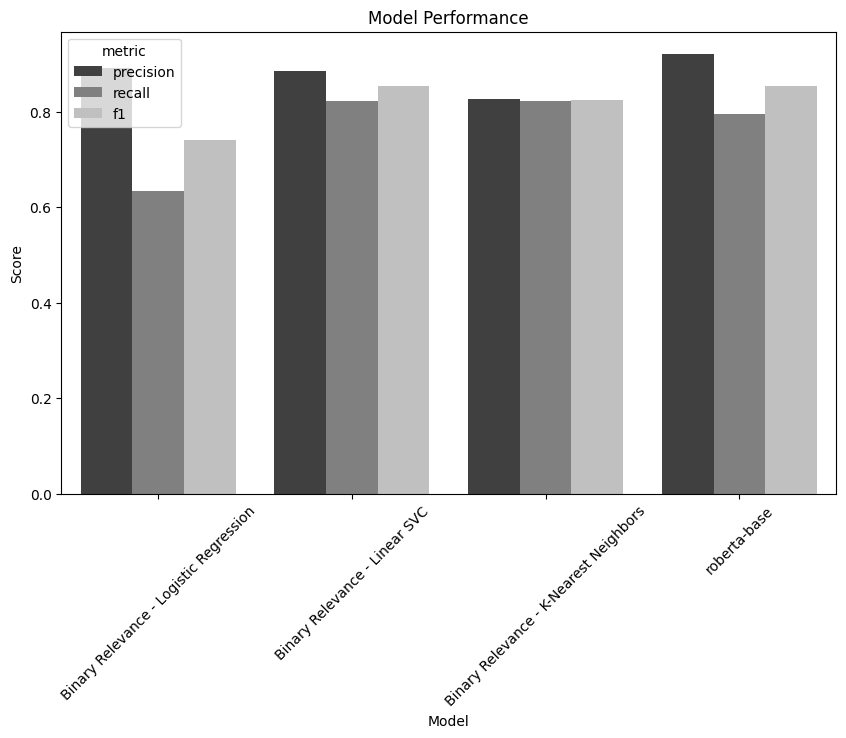

In [41]:
# plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=model_results_melt, x="model", y="value", hue="metric", palette="gray"
)
plt.title("Model Performance")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.show()